In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from scipy import optimize

In [2]:
import scipy.stats as st

In [3]:
from scipy.optimize import curve_fit

In [4]:
#read in files, make arrays, normalize by read counts in bin, normalize by cells collected, plot replicate correlations

## Read in files, make arrays, normalize

In [15]:
filenames = pd.read_csv('filenames1.csv')

In [88]:
array = np.zeros((144, 1201))

In [89]:
for i in range(144):
    filename = str(filenames.iloc[i, 0]) + '.csv'
    counts = pd.read_csv(filename)
    array[i][0] = int(counts.columns[1])
    array[i][1:] = [counts.values[j][1] for j in range(1200)]

In [90]:
array_transpose = np.transpose(array)

In [23]:
totals = np.sum(array, axis=1)

In [24]:
totals = totals.reshape(144,1)

In [ ]:
#calculate read frequencies for variants in each bin
norm_array = array/totals

In [92]:
OmpR_cells = pd.read_csv('OmpR_cells.csv')
RstA_cells = pd.read_csv('RstA_cells.csv')
CpxR_cells = pd.read_csv('CpxR_cells.csv')

In [93]:
OmpR_cells = OmpR_cells.iloc[:,1:]
RstA_cells = RstA_cells.iloc[:,1:]
CpxR_cells = CpxR_cells.iloc[:,1:]

In [ ]:
OmpR_totals = OmpR_cells.values.sum(axis=1)
OmpR_totals = OmpR_totals.reshape(6,1)
OmpR_cells_freq = OmpR_cells.values/OmpR_totals

RstA_totals = RstA_cells.values.sum(axis=1)
RstA_totals = RstA_totals.reshape(6,1)
RstA_cells_freq = RstA_cells.values/RstA_totals

CpxR_totals = CpxR_cells.values.sum(axis=1)
CpxR_totals = CpxR_totals.reshape(6,1)
CpxR_cells_freq = CpxR_cells.values/CpxR_totals

In [94]:
cells2_array = np.zeros((144,1))
cells2_array[:48] = OmpR_cells_freq.reshape(48,1)
cells2_array[48:96] = RstA_cells_freq.reshape(48,1)
cells2_array[96:] = CpxR_cells_freq.reshape(48,1)

In [ ]:
#normalize read frequencies by cells collected per bin
norm_cell_array_4 = norm_array*cells2_array

In [ ]:
norm_cell_4_transpose = np.transpose(norm_cell_array_4)

## Replicate correlations

In [ ]:
replicates = np.zeros((3,1201*16))
replicates[0] = norm_cell_array_4[:16].reshape(1,1201*16)
replicates[1] = norm_cell_array_4[16:32].reshape(1,1201*16)
replicates[2] = norm_cell_array_4[32:48].reshape(1,1201*16)

#plot OmpR replicate correlations
for reps in [(0,1),(0,2),(1,2)]:
    fig,ax = plt.subplots()
    fig.set_size_inches(5,5)
    plt.scatter(replicates[reps[0]][:], replicates[reps[1]][:],alpha = 0.1, rasterized = True, marker=".")
    plt.xlabel("rep1icate" + str(reps[0]+1))
    plt.ylabel("rep1icate" + str(reps[1]+1))
    plt.xlim((1e-8,1))
    plt.ylim((1e-8,1))
    plt.semilogy()
    plt.semilogx()
    Rsquared = st.pearsonr(replicates[reps[0]], replicates[reps[1]])[0]
    plt.title("Replicates %s-%s (R2 = %.3f)" % (str(reps[0]+1), str(reps[1]+1), Rsquared))
    #plt.savefig("norm_reads_OmpR reps %s-%s.pdf" % reps, dpi = 500)

## OmpR fitting functions

In [44]:
#bimodal fitting distribution
x3 = np.array([1,1.5,2,2.5,3,3.5,4,4.5])
def fit_gauss_OmpR_bimodal(ind, title = False, 
              plot = False,              #plot double bar graph, with fitted Gaussian overlay
              report_error = False,      #return error parameters from fitting
              mode_norm = False,          #normalize plot, so bar graphs have equal y-max
              plot_reps = False):        
    
    #extract normalized reads for query seq
    a = np.zeros((2,16))
    a[0,:8] = norm_cell_4_transpose[ind][:8]
    a[0,8:] = norm_cell_4_transpose[ind][8:16]
    a[1,:8] = norm_cell_4_transpose[ind][16:24]
    a[1,8:] = norm_cell_4_transpose[ind][40:48]
        
    #calculate mean reads/bin
    y1 = np.mean(a,axis = 0)[:8]
    y2 = np.mean(a,axis = 0)[8:]
    
    #plot replicates separately
    if plot_reps:
        plt.plot(a[:,:8].T, "r")
        plt.plot(a[:,8:].T,"b")
        plt.plot(y1, "r-", linestyle = "dashed",label = "OFF")
        plt.plot(y2,"b-", linestyle = "dashed",label = "ON")
        plt.legend()
        plt.figure()
    
    #if data is missing from one or both states, fail
    if y1.sum() ==0 or y2.sum() == 0:
        raise RuntimeError
    yerr1 = np.std(a,axis = 0,dtype=np.float64)[:8]
    yerr2 = np.std(a,axis = 0,dtype=np.float64)[8:]
    
    #add pseudocount to ensure no error value is 0
    pseudoc = 5e-7
    yerr1 = yerr1 + pseudoc
    yerr2 = yerr2 + pseudoc
    
    
    #scale both distributions together, for visually comparing distributions
    if mode_norm:
        yerr2 = np.array(map(lambda x: x * (max(y1)/max(y2)), yerr2))
        y2 = np.array(map(lambda x: x * (max(y1)/max(y2)), y2))
    
    failed = False
    
    #fit Gaussian for first condition
    def gaus_fixed_a1(x,x0,ymax,sigma):
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    def bimodal1(x,u1,ymax1,sigma1,u2,ymax2,sigma2):
        return gaus_fixed_a1(x,u1,ymax1,sigma1)+gaus_fixed_a1(x,u2,ymax2,sigma2)
    
    max_bin = np.argmax(y1)
    mode = x3[max_bin]
    guess = [mode,max(y1),0.5,mode,max(y1),0.5] 
    popt1,pcov1 = curve_fit(bimodal1,x3,y1, sigma = yerr1,absolute_sigma=True, bounds=([0.8,0,0,0.8,0,0],[4.7,0.2,1.5,4.7,0.2,1.5]), p0 = guess, maxfev=1000)
    perr1_1 = np.sqrt(np.diag(pcov1))
    if popt1[1] > popt1[4]:
        u_off = popt1[0]
        perr1 = perr1_1[:3]
    else:
        u_off = popt1[3]
        perr1 = perr1_1[3:]

    
    #fit Gaussian for second condition
    def gaus_fixed_a2(x,x0,ymax,sigma):
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    def bimodal2(x,u1,ymax1,sigma1,u2,ymax2,sigma2):
        return gaus_fixed_a2(x,u1,ymax1,sigma1)+gaus_fixed_a2(x,u2,ymax2,sigma2)
    
    max_bin = np.argmax(y2)
    mode = x3[max_bin]
    guess = [mode,max(y2),0.5,mode,max(y2),0.5] 
    popt2,pcov2 = curve_fit(bimodal2,x3,y2, sigma = yerr2,absolute_sigma=True, bounds=([0.8,0,0,0.8,0,0],[4.7,1,1.5,4.7,1,1.5]), p0 = guess, maxfev=1000)
    perr2_1 = np.sqrt(np.diag(pcov2))
    if popt2[1] > popt2[4]:
        u_on = popt2[0]
        perr2 = perr2_1[:3]
    else:
        u_on = popt2[3]
        perr2 = perr2_1[3:]

    fold_ind = 10**(u_on-u_off)
    
    #plot double bar graph
    if plot:
        plt.axvspan(u_off,u_on, facecolor='g',alpha = 0.1)
        opacity = 0.3
        error_config = {'ecolor': '0.3'}
        rects1 = plt.bar(x3,y1,.43,color='r',yerr = yerr1, error_kw=error_config, alpha=opacity, label = "OFF")
        rects2 = plt.bar(x3,y2,.43,color='b',yerr = yerr2, error_kw=error_config, alpha=opacity, label = "ON")

        plt.plot(np.arange(min(x3)-1, max(x3)+1, 0.1),bimodal1(np.arange(min(x3)-1, max(x3)+1, 0.1),*popt1),'r', alpha = 0.8)
        plt.plot(np.arange(min(x3)-1, max(x3)+1, 0.1),bimodal2(np.arange(min(x3)-1, max(x3)+1, 0.1),*popt2), 'b', alpha = 0.8)
        plt.ylabel("frequency in gate")
        plt.xlabel("log10( YFP )")
        plt.legend(loc = 2)
        plt.ylim([0,1.1*max(max(yerr1+y1) , max(yerr2+y2))])
        if title:
            title = str(ind)
            plt.savefig("gaussfit_OmpR"+title+".png")
        plt.figure()
    if report_error:
        return u_on,u_off,perr1,perr2
    else:
        return u_on,u_off,fold_ind

In [1]:
fit_gauss_OmpR_bimodal(479, plot=True, mode_norm=0, plot_reps = True, report_error=True, title=False)

NameError: name 'fit_gauss_OmpR_bimodal' is not defined

## Going through all variants (OmpR)

In [388]:
# # guassian fitting all sequences with bimodal fitting, saving to CSV

fit_failed = 0
handle = open("gauss_fit_OmpR_bimodal_filt.csv",'w')
handle.write('index,mean_on,mean_off,std_on,std_off,fold_induction\n')
for ind in range(1201):
    try:
        logu_on,logu_off,perr1,perr2= fit_gauss_OmpR_bimodal(ind, report_error= True)
        #on_counts = tcounts[ind][1:25].sum()
#         off_counts = tcounts[ind][25:49].sum()
        
#         #guassian mean estimates
        u_on = 10**logu_on
        u_off = 10**logu_off
        
#         #stdev of guassian mean estimates (from curve_Fit)
        std_on = perr1[0] * u_on/logu_on
        std_off = perr2[0] * u_off/logu_off
        
#         #fold induction
        fi = u_on/u_off
        
        handle.write(str(ind)+","+str(logu_on)+","+str(logu_off)+","+str(std_on)+","+str(std_off)+","+str(fi)+"\n")
    except RuntimeError:
        fit_failed += 1
        continue
    if ind%100 == 0:
        print(str(ind)+' sequences complete')
print(fit_failed)

0 sequences complete
100 sequences complete
200 sequences complete
300 sequences complete
400 sequences complete
500 sequences complete
600 sequences complete
700 sequences complete
800 sequences complete
900 sequences complete
1000 sequences complete
1100 sequences complete
1200 sequences complete
3


## RstA fitting

In [84]:
def fit_gauss_RstA_bimodal(ind, title = False, 
              plot = False,              #plot double bar graph, with fitted Gaussian overlay
              report_error = False,      #return error parameters from fitting
              mode_norm = False,          #normalize plot, so bar graphs have equal y-max
              plot_reps = False):        
    
    #extract normalized reads for query seq
    a = np.zeros((3,16))
    for rep in range(3):
        a[rep,:8] = norm_cell_4_transpose[ind][48+rep*16:56+rep*16]
        a[rep,8:] = norm_cell_4_transpose[ind][56+rep*16:64+rep*16]
        a[0,7] = np.mean([norm_cell_4_transpose[ind][71],norm_cell_4_transpose[ind][87]])
    
    
    #calculate mean reads/bin
    y1 = np.mean(a,axis = 0)[:8]
    y2 = np.mean(a,axis = 0)[8:]
    
    #plot replicates separately
    if plot_reps:
        plt.plot(a[:,:8].T, "r")
        plt.plot(a[:,8:].T,"b")
        plt.plot(y1, "r-", linestyle = "dashed",label = "OFF")
        plt.plot(y2,"b-", linestyle = "dashed",label = "ON")
        plt.legend()
        plt.figure()
    
    #if data is missing from one or both states, fail
    if y1.sum() ==0 or y2.sum() == 0:
        raise RuntimeError
    yerr1 = np.std(a,axis = 0,dtype=np.float64)[:8]
    yerr2 = np.std(a,axis = 0,dtype=np.float64)[8:]
    
    #add pseudocount to ensure no error value is 0
    pseudoc = 5e-7
    yerr1 = yerr1 + pseudoc
    yerr2 = yerr2 + pseudoc
    
    
    #scale both distributions together, for visually comparing distributions
    if mode_norm:
        yerr2 = np.array(map(lambda x: x * (max(y1)/max(y2)), yerr2))
        y2 = np.array(map(lambda x: x * (max(y1)/max(y2)), y2))
    
    failed = False
    
    #fit Gaussian for first condition
    def gaus_fixed_a1(x,x0,ymax,sigma):
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    def bimodal1(x,u1,ymax1,sigma1,u2,ymax2,sigma2):
        return gaus_fixed_a1(x,u1,ymax1,sigma1)+gaus_fixed_a1(x,u2,ymax2,sigma2)
    
    max_bin = np.argmax(y1)
    mode = x3[max_bin]
    guess = [mode,max(y1),0.5,mode,max(y1),0.5] 
    popt1,pcov1 = curve_fit(bimodal1,x3,y1, sigma = yerr1,absolute_sigma=True, bounds=([0.8,0,0,0.8,0,0],[4.7,0.2,1.5,4.7,0.2,1.5]), p0 = guess, maxfev=1000)
    perr1_1 = np.sqrt(np.diag(pcov1))
    if popt1[1] > popt1[4]:
        u_off = popt1[0]
        perr1 = perr1_1[:3]
    else:
        u_off = popt1[3]
        perr1 = perr1_1[3:]

    
    #fit Gaussian for second condition
    def gaus_fixed_a2(x,x0,ymax,sigma):
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    def bimodal2(x,u1,ymax1,sigma1,u2,ymax2,sigma2):
        return gaus_fixed_a2(x,u1,ymax1,sigma1)+gaus_fixed_a2(x,u2,ymax2,sigma2)
    
    max_bin = np.argmax(y2)
    mode = x3[max_bin]
    guess = [mode,max(y2),0.5,mode,max(y2),0.5] 
    popt2,pcov2 = curve_fit(bimodal2,x3,y2, sigma = yerr2,absolute_sigma=True, bounds=([0.8,0,0,0.8,0,0],[4.7,0.2,1.5,4.7,0.2,1.5]), p0 = guess, maxfev=100000)
    perr2_1 = np.sqrt(np.diag(pcov2))
    if popt2[1] > popt2[4]:
        u_on = popt2[0]
        perr2 = perr2_1[:3]
    else:
        u_on = popt2[3]
        perr2 = perr2_1[3:]

    fold_ind = 10**(u_on-u_off)
    
    #plot double bar graph
    if plot:
        #plt.axvspan(u_off,u_on, facecolor='g',alpha = 0.1)
        opacity = 0.6
        error_config = {'ecolor': '0.3'}
        #rects1 = plt.bar(x3,y1,.43,color='r',yerr = yerr1, error_kw=error_config, alpha=opacity, label = "OFF")
        rects2 = plt.bar(x3,y2,.43,color='orange',yerr = yerr2, error_kw=error_config, alpha=opacity), #label = "ON")

        #plt.plot(np.arange(min(x3)-1, max(x3)+1, 0.1),bimodal1(np.arange(min(x3)-1, max(x3)+1, 0.1),*popt1),'r', alpha = 0.8)
        plt.plot(np.arange(min(x3)-1, max(x3)+1, 0.1),bimodal2(np.arange(min(x3)-1, max(x3)+1, 0.1),*popt2), 'darkorange')
        plt.ylabel("frequency in gate")
        plt.xlabel("log10( YFP )")
        #plt.legend(loc = 2)
        plt.ylim([0,1.1*max(yerr2+y2)])
        if title:
            title = str(ind)
            plt.savefig("gaussfit_RstA"+title+".pdf",dpi=600)
        plt.figure()
    if report_error:
        return u_on,u_off,perr1,perr2
    else:
        return u_on,u_off,fold_ind

(3.930438515349049,
 3.7919255708508337,
 array([1.85135964e-02, 5.58923583e-06, 7.93279214e-02]),
 array([5.66047355e-02, 8.72997618e-06, 1.94830516e-01]))

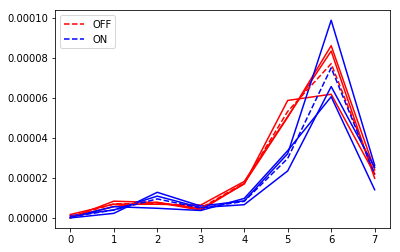

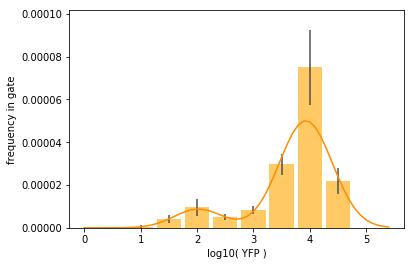

<Figure size 432x288 with 0 Axes>

In [648]:
fit_gauss_RstA_bimodal(787, plot=True, mode_norm=0, plot_reps = True, report_error=True, title=False)

## Going through all variants (RstA)

In [389]:
# # guassian fitting all sequences with bimodal, saving to CSV

# # can take ~1hr
fit_failed = 0
handle = open("gauss_fit_RstA_bimodal_filt.csv",'w')
handle.write('index,mean_on,mean_off,std_on,std_off,fold_induction\n')
for ind in range(1201):
    try:
        logu_on,logu_off,perr1,perr2= fit_gauss_RstA_bimodal(ind, report_error= True)
        #on_counts = tcounts[ind][1:25].sum()
#         off_counts = tcounts[ind][25:49].sum()
        
#         #guassian mean estimates
        u_on = 10**logu_on
        u_off = 10**logu_off
        
#         #stdev of guassian mean estimates (from curve_Fit)
        std_on = perr1[0] * u_on/logu_on
        std_off = perr2[0] * u_off/logu_off
        
#         #fold induction
        fi = u_on/u_off
        
        handle.write(str(ind)+","+str(logu_on)+","+str(logu_off)+","+str(std_on)+","+str(std_off)+","+str(fi)+"\n")
    except RuntimeError:
        fit_failed += 1
        continue
    if ind%100 == 0:
        print(str(ind)+' sequences complete')
print(fit_failed)

0 sequences complete
100 sequences complete
200 sequences complete
300 sequences complete
400 sequences complete
500 sequences complete
600 sequences complete
700 sequences complete
800 sequences complete
900 sequences complete
1000 sequences complete
1100 sequences complete
1200 sequences complete
1


## Fitting CpxR

In [86]:
def fit_gauss_CpxR_bimodal(ind, title = False, 
              plot = False,              #plot double bar graph, with fitted Gaussian overlay
              report_error = False,      #return error parameters from fitting
              mode_norm = False,          #normalize plot, so bar graphs have equal y-max
              plot_reps = False):        
    
    #extract normalized reads for query seq
    a = np.zeros((3,16))
    for rep in range(3):
        a[rep,:8] = norm_cell_4_transpose[ind][96+rep*16:104+rep*16]
        a[rep,8:] = norm_cell_4_transpose[ind][104+rep*16:112+rep*16]
        
    #calculate mean reads/bin
    y1 = np.mean(a,axis = 0)[:8]
    y2 = np.mean(a,axis = 0)[8:]
    
    #plot replicates separately
    if plot_reps:
        plt.plot(a[:,:8].T, "r")
        plt.plot(a[:,8:].T,"b")
        plt.plot(y1, "r-", linestyle = "dashed",label = "OFF")
        plt.plot(y2,"b-", linestyle = "dashed",label = "ON")
        plt.legend()
        plt.figure()
    
    #if data is missing from one or both states, fail
    if y1.sum() ==0 or y2.sum() == 0:
        raise RuntimeError
    yerr1 = np.std(a,axis = 0,dtype=np.float64)[:8]
    yerr2 = np.std(a,axis = 0,dtype=np.float64)[8:]
    
    #add pseudocount to ensure no error value is 0
    pseudoc = 5e-7
    yerr1 = yerr1 + pseudoc
    yerr2 = yerr2 + pseudoc
    
    
    #scale both distributions together, for visually comparing distributions
    if mode_norm:
        yerr2 = np.array(map(lambda x: x * (max(y1)/max(y2)), yerr2))
        y2 = np.array(map(lambda x: x * (max(y1)/max(y2)), y2))
    
    failed = False
    
    #fit Gaussian for first condition
    def gaus_fixed_a1(x,x0,ymax,sigma):
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    def bimodal1(x,u1,ymax1,sigma1,u2,ymax2,sigma2):
        return gaus_fixed_a1(x,u1,ymax1,sigma1)+gaus_fixed_a1(x,u2,ymax2,sigma2)
    
    max_bin = np.argmax(y1)
    mode = x3[max_bin]
    guess = [mode,max(y1),0.5,mode,max(y1),0.5] 
    popt1,pcov1 = curve_fit(bimodal1,x3,y1, sigma = yerr1,absolute_sigma=True, bounds=([0.8,0,0,0.8,0,0],[4.7,0.2,1.5,4.7,0.2,1.5]), p0 = guess, maxfev=1000)
    perr1_1 = np.sqrt(np.diag(pcov1))
    if popt1[1] > popt1[4]:
        u_off = popt1[0]
        perr1 = perr1_1[:3]
    else:
        u_off = popt1[3]
        perr1 = perr1_1[3:]

    
    #fit Gaussian for second condition
    def gaus_fixed_a2(x,x0,ymax,sigma):
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    def bimodal2(x,u1,ymax1,sigma1,u2,ymax2,sigma2):
        return gaus_fixed_a2(x,u1,ymax1,sigma1)+gaus_fixed_a2(x,u2,ymax2,sigma2)
    
    max_bin = np.argmax(y2)
    mode = x3[max_bin]
    guess = [mode,max(y2),0.5,mode,max(y2),0.5] 
    popt2,pcov2 = curve_fit(bimodal2,x3,y2, sigma = yerr2,absolute_sigma=True, bounds=([0.8,0,0,0.8,0,0],[4.7,1,1.5,4.7,1,1.5]), p0 = guess, maxfev=1000)
    perr2_1 = np.sqrt(np.diag(pcov2))
    if popt2[1] > popt2[4]:
        u_on = popt2[0]
        perr2 = perr2_1[:3]
    else:
        u_on = popt2[3]
        perr2 = perr2_1[3:]

    fold_ind = 10**(u_on-u_off)
    
    #plot double bar graph
    if plot:
        #plt.axvspan(u_off,u_on, facecolor='g',alpha = 0.1)
        opacity = 0.6
        error_config = {'ecolor': '0.3'}
        #rects1 = plt.bar(x3,y1,.43,color='r',yerr = yerr1, error_kw=error_config, alpha=opacity, label = "OFF")
        rects2 = plt.bar(x3,y2,.43,color='grey',yerr = yerr2, error_kw=error_config, alpha=opacity, label = "ON")

        #plt.plot(np.arange(min(x3)-1, max(x3)+1, 0.1),bimodal1(np.arange(min(x3)-1, max(x3)+1, 0.1),*popt1),'r', alpha = 0.8)
        plt.plot(np.arange(min(x3)-1, max(x3)+1, 0.1),bimodal2(np.arange(min(x3)-1, max(x3)+1, 0.1),*popt2), 'black', alpha = 0.8)
        plt.ylabel("frequency in gate")
        plt.xlabel("log10( GFP )")
        #plt.legend(loc = 2)
        #plt.ylim([0,1.1*max(max(yerr1+y1) , max(yerr2+y2))])
        if title:
            title = str(ind)
            plt.savefig("gaussfit_CpxR"+title+".pdf", dpi=600)
        plt.figure()
    if report_error:
        return u_on,u_off,perr1,perr2
    else:
        return u_on,u_off,fold_ind

(3.026361267389345,
 1.7307608869259499,
 array([1.75777034e-01, 5.14474334e-06, 5.82837891e-01]),
 array([4.15116499e-02, 1.32127319e-05, 6.91670346e-02]))

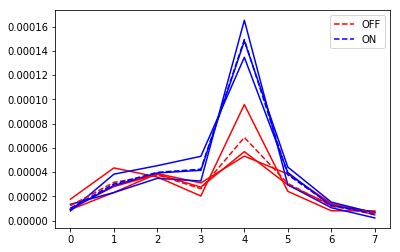

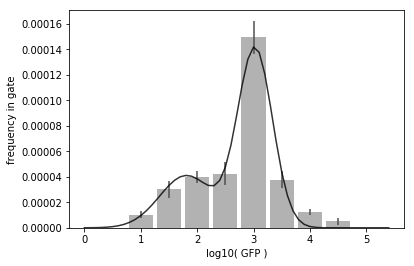

<Figure size 432x288 with 0 Axes>

In [640]:
fit_gauss_CpxR_bimodal(41, plot=True, mode_norm=0, plot_reps = True, title=False, report_error=True )

## Going through all variants (CpxR)

In [390]:
# # guassian fitting all sequences with bimodal, saving to CSV

# # can take ~1hr
fit_failed = 0
handle = open("gauss_fit_CpxR_bimodal_filt.csv",'w')
handle.write('index,mean_on,mean_off,std_on,std_off,fold_induction\n')
for ind in range(1201):
    try:
        logu_on,logu_off,perr1,perr2= fit_gauss_CpxR_bimodal(ind, report_error= True)
        #on_counts = tcounts[ind][1:25].sum()
#         off_counts = tcounts[ind][25:49].sum()
        
#         #guassian mean estimates
        u_on = 10**logu_on
        u_off = 10**logu_off
        
#         #stdev of guassian mean estimates (from curve_Fit)
        std_on = perr1[0] * u_on/logu_on
        std_off = perr2[0] * u_off/logu_off
        
#         #fold induction
        fi = u_on/u_off
        
        handle.write(str(ind)+","+str(logu_on)+","+str(logu_off)+","+str(std_on)+","+str(std_off)+","+str(fi)+"\n")
    except RuntimeError:
        fit_failed += 1
        continue
    if ind%100 == 0:
        print(str(ind)+' sequences complete')
print(fit_failed)

0 sequences complete
100 sequences complete
200 sequences complete
300 sequences complete
400 sequences complete
500 sequences complete
600 sequences complete
700 sequences complete
800 sequences complete
900 sequences complete
1000 sequences complete
1100 sequences complete
1200 sequences complete
0
